In [21]:
#/usr/bin/env python
#coding=utf-8
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from matplotlib import pyplot as plt
import numpy as np

In [22]:
# import torchsummary
#epoch 100, lr, 0.1 and uopdate, batch 256

num_epoches = 20
learning_rate = 0.1
feature_learning_rate = 0.001
num_classes  = 9
batchsize = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [23]:
class newresnet(torch.nn.Module):
    def __init__(self):
        super(newresnet, self).__init__()

        self.newresnet18  = torchvision.models.resnet18(pretrained = True)
        # for param in self.newresnet18.parameters():
        #     param.requires_grad = False
        # here in_feature is 512*block.expansion
        num_ftrs = self.newresnet18.fc.in_features 

        # remove the last fc layer
        # myresnet = torch.nn.Sequential(*list(myresnet.children())[:-1])
        self.newresnet18.fc = torch.nn.Identity()
        self.fc = torch.nn.Linear(num_ftrs, num_classes)
    def forward(self,x):
        x = self.newresnet18(x)
        # x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [24]:
#For updating learning rate
def update_lr(optimizer, divide = 2):
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr']/divide

In [25]:
# predict
def predict(model, loader):
    model.to(device)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        all_predicted = []
        labels_total = []
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)# _ are max values, predicts are their indexs
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predicted += predicted.cpu().numpy().tolist()
            labels_total += labels.cpu().numpy().tolist()
        
        print("Accuracy: {}%" .format(100* correct/total))
    model.train()
    return all_predicted, labels_total, 100* correct/total

In [26]:
myresnet = newresnet()
myresnet.to(device)

newresnet(
  (newresnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [27]:
#required size Resnet 224, 224
#              Inception v3 N x 3 x 299 x 299
resize  = torchvision.transforms.Resize((224, 224))
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])## need mean and std
preprocessor = torchvision.transforms.Compose([ 
                                               torchvision.transforms.RandomRotation(20),
                                               torchvision.transforms.RandomHorizontalFlip(),
                                               resize,
                                               torchvision.transforms.ToTensor(), 
                                               normalize,
                                               ])
#preprocessor = torchvision.transforms.Compose([resize, torchvision.transforms.ToTensor()])

#load train data
#data_dir = '../../data/'
#data_dir = '/System/Volumes/Data/data/'
#root/dog/xxx.png
# root/cat/123.png

In [28]:
path = r'C:\Users\ZXY\Desktop\ASU\ProgramCourses\2020spring\EEE511\HW\Final\dataset3'
data_dir_train = path + r'\train'

train_dataset = torchvision.datasets.ImageFolder(root = data_dir_train,
                                                 transform = preprocessor)
for load_num in range(10):
    train_dataset2 = torchvision.datasets.ImageFolder(root = data_dir_train,
                                                 transform = preprocessor)
    train_dataset+=train_dataset2

validation_dataset,  train_dataset_1= torch.utils.data.random_split(train_dataset, (int(0.2*len(train_dataset)), len(train_dataset)-int(0.2*len(train_dataset))))
print('train_dataset size:', len(train_dataset))
print('validation_dataset size:', len(validation_dataset))
print('train_dataset_1 size:', len(train_dataset_1))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset_1,
                                            batch_size = batchsize,
                                            shuffle = True)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset,
                                            batch_size = batchsize,
                                            shuffle = True)
print('train_loader size:', len(train_loader))
print('validation_loader size:', len(validation_loader))

#load test data
data_dir_test = path + r'\test'
test_dataset = torchvision.datasets.ImageFolder(root = data_dir_test,
                                               transform = preprocessor)
print('test_dataset size:', len(test_dataset))

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batchsize,
                                          shuffle = False)
print('test_loader size:', len(test_loader))

train_dataset size: 10164
validation_dataset size: 2032
train_dataset_1 size: 8132
train_loader size: 64
validation_loader size: 16
test_dataset size: 56
test_loader size: 1


In [29]:
#loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([{'params':myresnet.newresnet18.parameters(), 'lr': feature_learning_rate},
                             {'params':myresnet.fc.parameters()}
                             ], 
                             lr = learning_rate)

In [30]:
for i, (images, labels) in enumerate(train_loader):
    print(images)
    print(labels)
    break

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

        2, 6, 5, 5, 3, 6, 4, 1])


In [31]:

#Train the model
total_step = len(train_loader)
curr_lr = learning_rate
hist = np.zeros(num_epoches)
accuracy_train = np.zeros(num_epoches)
accuracy_test = np.zeros(num_epoches)
accuracy_val = np.zeros(num_epoches)

myresnet.train()
for epoch in range(num_epoches):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        #print(images.data.type())
        #print(labels)
        #forward
        outputs = myresnet.forward(images)
        #print(outputs.data.type())
        #loss function
        loss = criterion(outputs, labels)
        hist[epoch] = loss.item()

        optimizer.zero_grad()
        #backward 
        loss.backward()

        #optimize
        optimizer.step()
        
        # if abs(predict(myresnet, train_loader)-predict(myresnet, validation_loader))<5:
        #     loss.backward()
        #     optimizer.step()

        if (i+1)%1 == 0:
            print("Epoch [{}/{}], Step[{}/{}] Loss:{:.4f}" 
                .format(epoch+1, num_epoches, i+1, total_step, loss.item() ))


    
    if (epoch+1)%1 == 0:
        update_lr(optimizer, 1.1)
        #_ = predict(myresnet, validation_loader)
        #_,__ , accuracy_train[epoch]= predict(myresnet, train_loader)
        _,__ , accuracy_val[epoch]= predict(myresnet, validation_loader)
        _,__ , accuracy_test[epoch]= predict(myresnet, test_loader)

Epoch [1/20], Step[1/64] Loss:2.5959
Epoch [1/20], Step[2/64] Loss:4.2904
Epoch [1/20], Step[3/64] Loss:6.6696
Epoch [1/20], Step[4/64] Loss:8.7513
Epoch [1/20], Step[5/64] Loss:10.7951
Epoch [1/20], Step[6/64] Loss:10.0964
Epoch [1/20], Step[7/64] Loss:11.8943
Epoch [1/20], Step[8/64] Loss:10.8366
Epoch [1/20], Step[9/64] Loss:12.0228
Epoch [1/20], Step[10/64] Loss:8.6016
Epoch [1/20], Step[11/64] Loss:10.0952
Epoch [1/20], Step[12/64] Loss:9.9397
Epoch [1/20], Step[13/64] Loss:9.9476
Epoch [1/20], Step[14/64] Loss:7.9616
Epoch [1/20], Step[15/64] Loss:6.2643
Epoch [1/20], Step[16/64] Loss:6.6543
Epoch [1/20], Step[17/64] Loss:4.5640
Epoch [1/20], Step[18/64] Loss:6.9934
Epoch [1/20], Step[19/64] Loss:7.7181
Epoch [1/20], Step[20/64] Loss:8.1641
Epoch [1/20], Step[21/64] Loss:9.6909
Epoch [1/20], Step[22/64] Loss:9.4365
Epoch [1/20], Step[23/64] Loss:6.1234
Epoch [1/20], Step[24/64] Loss:5.7029
Epoch [1/20], Step[25/64] Loss:5.3809
Epoch [1/20], Step[26/64] Loss:7.2098
Epoch [1/20], S

Epoch [4/20], Step[20/64] Loss:0.2579
Epoch [4/20], Step[21/64] Loss:0.2364
Epoch [4/20], Step[22/64] Loss:0.1813
Epoch [4/20], Step[23/64] Loss:0.2559
Epoch [4/20], Step[24/64] Loss:0.2307
Epoch [4/20], Step[25/64] Loss:0.2677
Epoch [4/20], Step[26/64] Loss:0.4068
Epoch [4/20], Step[27/64] Loss:0.2230
Epoch [4/20], Step[28/64] Loss:0.1936
Epoch [4/20], Step[29/64] Loss:0.2331
Epoch [4/20], Step[30/64] Loss:0.2736
Epoch [4/20], Step[31/64] Loss:0.1954
Epoch [4/20], Step[32/64] Loss:0.1729
Epoch [4/20], Step[33/64] Loss:0.2251
Epoch [4/20], Step[34/64] Loss:0.1844
Epoch [4/20], Step[35/64] Loss:0.3097
Epoch [4/20], Step[36/64] Loss:0.2638
Epoch [4/20], Step[37/64] Loss:0.1947
Epoch [4/20], Step[38/64] Loss:0.2508
Epoch [4/20], Step[39/64] Loss:0.2388
Epoch [4/20], Step[40/64] Loss:0.2369
Epoch [4/20], Step[41/64] Loss:0.1992
Epoch [4/20], Step[42/64] Loss:0.1737
Epoch [4/20], Step[43/64] Loss:0.2735
Epoch [4/20], Step[44/64] Loss:0.2219
Epoch [4/20], Step[45/64] Loss:0.2336
Epoch [4/20]

Epoch [7/20], Step[40/64] Loss:0.1798
Epoch [7/20], Step[41/64] Loss:0.1126
Epoch [7/20], Step[42/64] Loss:0.1517
Epoch [7/20], Step[43/64] Loss:0.1206
Epoch [7/20], Step[44/64] Loss:0.1576
Epoch [7/20], Step[45/64] Loss:0.1930
Epoch [7/20], Step[46/64] Loss:0.1451
Epoch [7/20], Step[47/64] Loss:0.1313
Epoch [7/20], Step[48/64] Loss:0.1129
Epoch [7/20], Step[49/64] Loss:0.1386
Epoch [7/20], Step[50/64] Loss:0.1416
Epoch [7/20], Step[51/64] Loss:0.1250
Epoch [7/20], Step[52/64] Loss:0.1808
Epoch [7/20], Step[53/64] Loss:0.1243
Epoch [7/20], Step[54/64] Loss:0.1332
Epoch [7/20], Step[55/64] Loss:0.1501
Epoch [7/20], Step[56/64] Loss:0.2476
Epoch [7/20], Step[57/64] Loss:0.1391
Epoch [7/20], Step[58/64] Loss:0.0732
Epoch [7/20], Step[59/64] Loss:0.1204
Epoch [7/20], Step[60/64] Loss:0.1499
Epoch [7/20], Step[61/64] Loss:0.0734
Epoch [7/20], Step[62/64] Loss:0.1374
Epoch [7/20], Step[63/64] Loss:0.1389
Epoch [7/20], Step[64/64] Loss:0.1597
Accuracy: 95.71850393700787%
Accuracy: 87.5%
Epoch

Epoch [10/20], Step[58/64] Loss:0.1141
Epoch [10/20], Step[59/64] Loss:0.1007
Epoch [10/20], Step[60/64] Loss:0.0570
Epoch [10/20], Step[61/64] Loss:0.1007
Epoch [10/20], Step[62/64] Loss:0.1043
Epoch [10/20], Step[63/64] Loss:0.1047
Epoch [10/20], Step[64/64] Loss:0.1300
Accuracy: 97.68700787401575%
Accuracy: 91.07142857142857%
Epoch [11/20], Step[1/64] Loss:0.0897
Epoch [11/20], Step[2/64] Loss:0.0929
Epoch [11/20], Step[3/64] Loss:0.0879
Epoch [11/20], Step[4/64] Loss:0.0647
Epoch [11/20], Step[5/64] Loss:0.0828
Epoch [11/20], Step[6/64] Loss:0.0582
Epoch [11/20], Step[7/64] Loss:0.0747
Epoch [11/20], Step[8/64] Loss:0.0602
Epoch [11/20], Step[9/64] Loss:0.0886
Epoch [11/20], Step[10/64] Loss:0.1146
Epoch [11/20], Step[11/64] Loss:0.0772
Epoch [11/20], Step[12/64] Loss:0.0737
Epoch [11/20], Step[13/64] Loss:0.0715
Epoch [11/20], Step[14/64] Loss:0.0958
Epoch [11/20], Step[15/64] Loss:0.0873
Epoch [11/20], Step[16/64] Loss:0.0690
Epoch [11/20], Step[17/64] Loss:0.0846
Epoch [11/20], 

Epoch [14/20], Step[7/64] Loss:0.0973
Epoch [14/20], Step[8/64] Loss:0.0951
Epoch [14/20], Step[9/64] Loss:0.0571
Epoch [14/20], Step[10/64] Loss:0.0702
Epoch [14/20], Step[11/64] Loss:0.0877
Epoch [14/20], Step[12/64] Loss:0.0724
Epoch [14/20], Step[13/64] Loss:0.0581
Epoch [14/20], Step[14/64] Loss:0.1128
Epoch [14/20], Step[15/64] Loss:0.1037
Epoch [14/20], Step[16/64] Loss:0.0989
Epoch [14/20], Step[17/64] Loss:0.0755
Epoch [14/20], Step[18/64] Loss:0.0684
Epoch [14/20], Step[19/64] Loss:0.0801
Epoch [14/20], Step[20/64] Loss:0.1109
Epoch [14/20], Step[21/64] Loss:0.0686
Epoch [14/20], Step[22/64] Loss:0.1028
Epoch [14/20], Step[23/64] Loss:0.0815
Epoch [14/20], Step[24/64] Loss:0.0603
Epoch [14/20], Step[25/64] Loss:0.0740
Epoch [14/20], Step[26/64] Loss:0.0624
Epoch [14/20], Step[27/64] Loss:0.0818
Epoch [14/20], Step[28/64] Loss:0.0534
Epoch [14/20], Step[29/64] Loss:0.0736
Epoch [14/20], Step[30/64] Loss:0.0766
Epoch [14/20], Step[31/64] Loss:0.0701
Epoch [14/20], Step[32/64] L

Epoch [17/20], Step[21/64] Loss:0.0767
Epoch [17/20], Step[22/64] Loss:0.1064
Epoch [17/20], Step[23/64] Loss:0.0610
Epoch [17/20], Step[24/64] Loss:0.0706
Epoch [17/20], Step[25/64] Loss:0.0798
Epoch [17/20], Step[26/64] Loss:0.0547
Epoch [17/20], Step[27/64] Loss:0.0991
Epoch [17/20], Step[28/64] Loss:0.0643
Epoch [17/20], Step[29/64] Loss:0.0438
Epoch [17/20], Step[30/64] Loss:0.0800
Epoch [17/20], Step[31/64] Loss:0.0649
Epoch [17/20], Step[32/64] Loss:0.0611
Epoch [17/20], Step[33/64] Loss:0.0458
Epoch [17/20], Step[34/64] Loss:0.0458
Epoch [17/20], Step[35/64] Loss:0.0547
Epoch [17/20], Step[36/64] Loss:0.0842
Epoch [17/20], Step[37/64] Loss:0.0678
Epoch [17/20], Step[38/64] Loss:0.0524
Epoch [17/20], Step[39/64] Loss:0.0733
Epoch [17/20], Step[40/64] Loss:0.0321
Epoch [17/20], Step[41/64] Loss:0.0386
Epoch [17/20], Step[42/64] Loss:0.0639
Epoch [17/20], Step[43/64] Loss:0.0949
Epoch [17/20], Step[44/64] Loss:0.0703
Epoch [17/20], Step[45/64] Loss:0.0570
Epoch [17/20], Step[46/64

Epoch [20/20], Step[35/64] Loss:0.0760
Epoch [20/20], Step[36/64] Loss:0.0644
Epoch [20/20], Step[37/64] Loss:0.0790
Epoch [20/20], Step[38/64] Loss:0.0622
Epoch [20/20], Step[39/64] Loss:0.0639
Epoch [20/20], Step[40/64] Loss:0.0459
Epoch [20/20], Step[41/64] Loss:0.0725
Epoch [20/20], Step[42/64] Loss:0.0566
Epoch [20/20], Step[43/64] Loss:0.0588
Epoch [20/20], Step[44/64] Loss:0.0387
Epoch [20/20], Step[45/64] Loss:0.0535
Epoch [20/20], Step[46/64] Loss:0.0480
Epoch [20/20], Step[47/64] Loss:0.0655
Epoch [20/20], Step[48/64] Loss:0.0923
Epoch [20/20], Step[49/64] Loss:0.0310
Epoch [20/20], Step[50/64] Loss:0.0746
Epoch [20/20], Step[51/64] Loss:0.0468
Epoch [20/20], Step[52/64] Loss:0.0490
Epoch [20/20], Step[53/64] Loss:0.0479
Epoch [20/20], Step[54/64] Loss:0.0274
Epoch [20/20], Step[55/64] Loss:0.0622
Epoch [20/20], Step[56/64] Loss:0.0770
Epoch [20/20], Step[57/64] Loss:0.0646
Epoch [20/20], Step[58/64] Loss:0.0822
Epoch [20/20], Step[59/64] Loss:0.0481
Epoch [20/20], Step[60/64

Accuracy: 85.71428571428571%


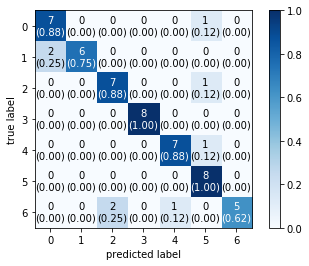

In [32]:
test_predicts, test_labels,_ = predict(myresnet, test_loader)
cm = metrics.confusion_matrix(test_labels, test_predicts)

fig,ax = plot_confusion_matrix(cm, colorbar = True, show_normed = True)
plt.show()

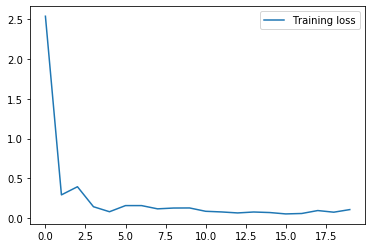

In [33]:
#####################
# Plot preds and performance
#####################

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

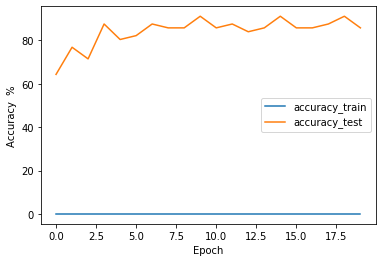

In [34]:
#####################
# Plot preds and performance
#####################

plt.plot(accuracy_train, label="accuracy_train")
plt.plot(accuracy_test, label="accuracy_test")
plt.xlabel('Epoch')
plt.ylabel('Accuracy  %')
plt.legend()
plt.show()

In [20]:
#plt.savefig("/datahub/iGEM2017/zxyremote/fineplusmodel.png")

#torch.save(myresnet.state_dict(),"C:/Users/xzhou145/Desktop/ASU/ProgramCourses/Courses/EEE508/Project2/feature.pt")
#torch.save(myresnet.state_dict(),"/datahub/iGEM2017/zxyremote/fineplusmodel.pt")

fname = "C:/Users/ZXY/Desktop/ASU/ProgramCourses/2020spring/EEE511/HW/Final/myresnet3.pt"
# for saving
torch.save(myresnet.state_dict(),fname)

# for loading
#model = # (use the class to initialize the model)
#model.load_state_dict(torch.load(fname))